In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve
)

In [20]:
RANDOM_STATE = 42
dataset_telco = "telco_customer_churn.xlsx" 

In [ ]:
# 1) Carga y limpieza base

df = pd.read_excel(dataset_telco, engine="openpyxl")

# Normaliza nombres (quita espacios)
df.columns = [c.strip() for c in df.columns]

print("Shape (raw):", df.shape)
print(df.head())

# Columnas que NO debes usar (leakage o irrelevantes)
drop_cols = [
    "CustomerID",
    "Count",
    "Lat Long",
    "Churn Label",   # redundante si usamos Churn Value
    "Churn Score",   # leakage (probable score calculado)
    "Churn Reason"   # leakage (razón posterior)
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Target 
target_col = "Churn Value"
if target_col not in df.columns:
    raise ValueError(f"No encuentro la columna objetivo '{target_col}'. Revisa tu dataset.")

# Asegura 0/1 en entero
df[target_col] = pd.to_numeric(df[target_col], errors="coerce").astype(int)

# Convertir numéricas que suelen venir como texto
numeric_cols = ["Tenure Months", "Monthly Charges", "Total Charges", "Zip Code", "Latitude", "Longitude", "CLTV"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Limpieza de strings (strip)
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str).str.strip()
    df.loc[df[col].isin(["", "nan", "NaN", "None"]), col] = np.nan

# Duplicados
dup = df.duplicated().sum()
print("\nDuplicados:", dup)
if dup > 0:
    df = df.drop_duplicates()

print("\nShape (clean):", df.shape)
print(df.head())


Shape (raw): (7043, 33)
   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Meth


Churn rate (tasa de cancelación): 26.54%

Churn por tipo de contrato:
Contract
Month-to-month    42.71%
One year          11.27%
Two year           2.83%
Name: Churn Value, dtype: object

Churn promedio por rango de antigüedad (Tenure Months):
tenure_group
0-6m      52.94%
7-12m     35.89%
13-24m    28.71%
25-48m    20.39%
49-72m     9.51%
73m+        nan%
Name: Churn Value, dtype: object


C:\Users\PC\AppData\Local\Temp\ipykernel_15656\2654918971.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("tenure_group")[target_col].mean().apply(lambda x: f"{x:.2%}"))


<Figure size 640x480 with 0 Axes>

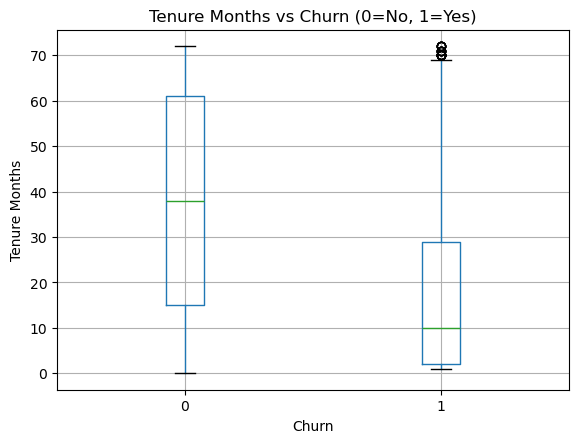

In [ ]:
# 2) Mini-EDA (enfocado)

churn_rate = df[target_col].mean()
print(f"\nChurn rate (tasa de cancelación): {churn_rate:.2%}")

# Churn por contrato
if "Contract" in df.columns:
    print("\nChurn por tipo de contrato:")
    print(df.groupby("Contract")[target_col].mean().sort_values(ascending=False).apply(lambda x: f"{x:.2%}"))

# Churn por rango de antigüedad (Tenure Months)
if "Tenure Months" in df.columns:
    print("\nChurn promedio por rango de antigüedad (Tenure Months):")
    bins = [-1, 6, 12, 24, 48, 72, 999]
    labels = ["0-6m", "7-12m", "13-24m", "25-48m", "49-72m", "73m+"]
    df["tenure_group"] = pd.cut(df["Tenure Months"], bins=bins, labels=labels)
    print(df.groupby("tenure_group")[target_col].mean().apply(lambda x: f"{x:.2%}"))

# Boxplot: Tenure Months vs churn
if "Tenure Months" in df.columns:
    plt.figure()
    df.boxplot(column="Tenure Months", by=target_col)
    plt.suptitle("")
    plt.title("Tenure Months vs Churn (0=No, 1=Yes)")
    plt.xlabel("Churn")
    plt.ylabel("Tenure Months")
    plt.show()


In [24]:
# 3) Split train/test

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nTrain:", X_train.shape, "Test:", X_test.shape)


Train: (5634, 27) Test: (1409, 27)


In [25]:
# 4) Preprocesamiento

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)


In [26]:
# 5) Modelos

log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    ))
])


def evaluate_model(pipeline, X_test, y_test, threshold=0.5, name="model"):
    """Evalúa con umbral configurable (importante para negocio)."""
    proba = pipeline.predict_proba(X_test)[:, 1]
    preds = (proba >= threshold).astype(int)

    auc = roc_auc_score(y_test, proba)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    cm = confusion_matrix(y_test, preds)

    print(f"\n=== {name} (threshold={threshold:.2f}) ===")
    print(f"AUC-ROC : {auc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    return {"auc": auc, "acc": acc, "precision": prec, "recall": rec, "f1": f1, "cm": cm, "proba": proba}


# Entrena
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Evalúa con threshold=0.50
res_lr = evaluate_model(log_reg, X_test, y_test, threshold=0.50, name="LogReg")
res_rf = evaluate_model(rf, X_test, y_test, threshold=0.50, name="RandomForest")


=== LogReg (threshold=0.50) ===
AUC-ROC : 0.8407
Accuracy: 0.7488
Precision: 0.5183
Recall   : 0.7567
F1-score : 0.6152
Confusion Matrix:
 [[772 263]
 [ 91 283]]

=== RandomForest (threshold=0.50) ===
AUC-ROC : 0.8476
Accuracy: 0.7999
Precision: 0.6565
Recall   : 0.5160
F1-score : 0.5778
Confusion Matrix:
 [[934 101]
 [181 193]]


In [27]:
# 6) Ajuste de umbral (negocio)

def find_threshold_for_recall(proba, y_true, min_precision=0.30):
    thresholds = np.linspace(0.05, 0.95, 19)
    best = None

    for t in thresholds:
        preds = (proba >= t).astype(int)
        prec = precision_score(y_true, preds, zero_division=0)
        rec = recall_score(y_true, preds, zero_division=0)
        f1 = f1_score(y_true, preds, zero_division=0)

        if prec >= min_precision:
            if best is None or rec > best["recall"] or (rec == best["recall"] and f1 > best["f1"]):
                best = {"threshold": t, "precision": prec, "recall": rec, "f1": f1}

    return best

best_lr = find_threshold_for_recall(res_lr["proba"], y_test, min_precision=0.30)
best_rf = find_threshold_for_recall(res_rf["proba"], y_test, min_precision=0.30)

print("\nMejor umbral (LogReg) con precision>=0.30:", best_lr)
print("Mejor umbral (RF)     con precision>=0.30:", best_rf)

if best_lr:
    evaluate_model(log_reg, X_test, y_test, threshold=best_lr["threshold"], name="LogReg tuned")

if best_rf:
    evaluate_model(rf, X_test, y_test, threshold=best_rf["threshold"], name="RandomForest tuned")


Mejor umbral (LogReg) con precision>=0.30: {'threshold': np.float64(0.05), 'precision': 0.3217391304347826, 'recall': 0.9893048128342246, 'f1': 0.48556430446194226}
Mejor umbral (RF)     con precision>=0.30: {'threshold': np.float64(0.05), 'precision': 0.3414179104477612, 'recall': 0.9786096256684492, 'f1': 0.5062240663900415}

=== LogReg tuned (threshold=0.05) ===
AUC-ROC : 0.8407
Accuracy: 0.4436
Precision: 0.3217
Recall   : 0.9893
F1-score : 0.4856
Confusion Matrix:
 [[255 780]
 [  4 370]]

=== RandomForest tuned (threshold=0.05) ===
AUC-ROC : 0.8476
Accuracy: 0.4933
Precision: 0.3414
Recall   : 0.9786
F1-score : 0.5062
Confusion Matrix:
 [[329 706]
 [  8 366]]


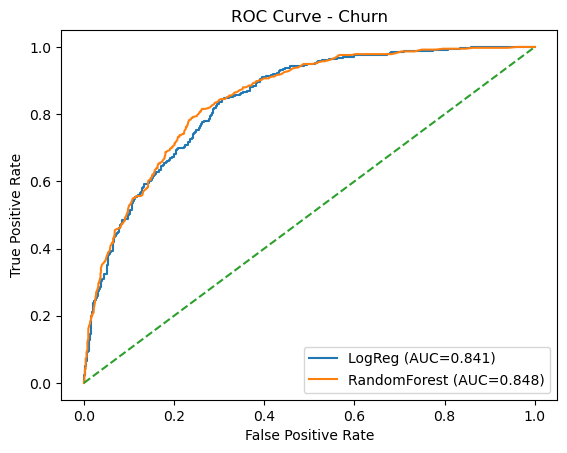

In [28]:
# 7) Curva ROC (visual)

plt.figure()
for name, proba in [("LogReg", res_lr["proba"]), ("RandomForest", res_rf["proba"])]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, proba):.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve - Churn")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Top 20 features (RandomForest):
                              feature  importance
5                       Total Charges    0.060744
3                       Tenure Months    0.058084
4                     Monthly Charges    0.049987
6                                CLTV    0.042586
1171          Contract_Month-to-month    0.040659
0                            Zip Code    0.040164
2                           Longitude    0.039683
1                            Latitude    0.039521
1173                Contract_Two year    0.023300
1162                  Tech Support_No    0.023255
1144                   Dependents_Yes    0.021576
1153               Online Security_No    0.020499
1143                    Dependents_No    0.020412
1151     Internet Service_Fiber optic    0.020274
1178  Payment Method_Electronic check    0.019903
1180                tenure_group_0-6m    0.017554
1183              tenure_group_49-72m    0.015212
1155              Online Security_Yes    0.012705
1172             

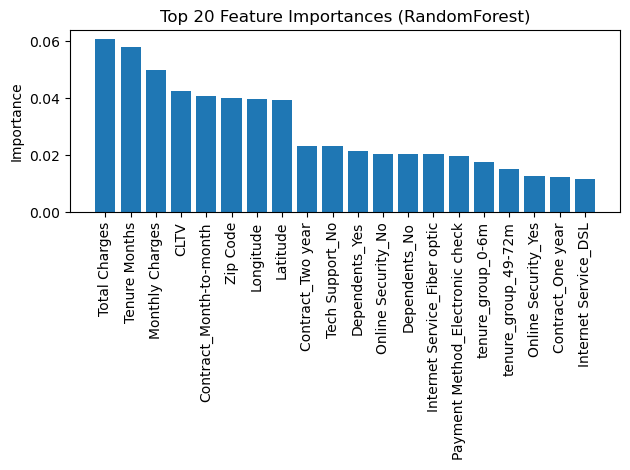

In [29]:
# 8) Importancia de variables (RF)

try:
    pre = rf.named_steps["preprocess"]
    model = rf.named_steps["model"]

    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    cat_names = ohe.get_feature_names_out(categorical_features)
    feature_names = np.concatenate([numeric_features, cat_names])

    importances = model.feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi = fi.sort_values("importance", ascending=False).head(20)

    print("\nTop 20 features (RandomForest):")
    print(fi)

    plt.figure()
    plt.bar(fi["feature"], fi["importance"])
    plt.title("Top 20 Feature Importances (RandomForest)")
    plt.xticks(rotation=90)
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("\nNo pude calcular feature importance con nombres (depende del dataset/versión). Error:", e)


In [30]:
# 9) Mini cálculo de impacto de negocio (ejemplo)

# Nota: en el dataset la columna se llama "Monthly Charges"
if "Monthly Charges" in X_test.columns:
    chosen = rf
    chosen_name = "RandomForest tuned" if best_rf else "RandomForest"
    chosen_threshold = best_rf["threshold"] if best_rf else 0.50

    proba = chosen.predict_proba(X_test)[:, 1]
    preds = (proba >= chosen_threshold).astype(int)

    flagged = X_test.loc[preds == 1].copy()
    y_flagged = y_test.loc[flagged.index]

    true_churn_flagged = flagged.loc[y_flagged == 1]

    retention_rate = 0.30
    avg_monthly = true_churn_flagged["Monthly Charges"].mean() if len(true_churn_flagged) > 0 else 0.0

    estimated_saved_customers = int(round(len(true_churn_flagged) * retention_rate))
    estimated_annual_revenue_saved = estimated_saved_customers * (12 * avg_monthly)

    print(f"\n=== Impacto de negocio (estimación) - {chosen_name} ===")
    print(f"Clientes marcados para campaña: {len(flagged)}")
    print(f"Verdaderos churn dentro de marcados: {len(true_churn_flagged)}")
    print(f"Tasa de retención asumida: {retention_rate:.0%}")
    print(f"Clientes salvados estimados: {estimated_saved_customers}")
    print(f"Ingreso anual salvado estimado (simplificado): ${estimated_annual_revenue_saved:,.2f}")
else:
    print("\nNo hay columna 'Monthly Charges'; omito cálculo de impacto.")


=== Impacto de negocio (estimación) - RandomForest tuned ===
Clientes marcados para campaña: 1072
Verdaderos churn dentro de marcados: 366
Tasa de retención asumida: 30%
Clientes salvados estimados: 110
Ingreso anual salvado estimado (simplificado): $96,843.10
